<a href="https://colab.research.google.com/github/Karimby1/CMR_stage/blob/Pr%C3%A9diction-Finale/runners_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.4 MB/s eta 0:00:00


In [5]:
from google.colab import drive
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 1. Mount Google Drive and load data
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/oo.xlsx'

# Load the Excel file (correct for .xlsx)
df = pd.read_excel(file_path)

# Check columns to confirm names
print("✅ Columns in the dataset:")
print(df.columns)

# 2. Rename and preprocess
# Rename original columns to match what you want
df.rename(columns={
    'DatePhysical': 'date_convertit',
    'Product': 'Product_nettoyée'
}, inplace=True)

# Convert date
df['date_convertit'] = pd.to_datetime(df['date_convertit'], dayfirst=True, errors='coerce')
df['Year'] = df['date_convertit'].dt.year
df['Month'] = df['date_convertit'].dt.month

# Drop rows with missing required fields
required_columns = ['Product_nettoyée', 'QTY', 'Year', 'Month', 'UnitCostToEuro', 'RRS_Purchase']
df = df.dropna(subset=required_columns)

# Encode product names
le_product = LabelEncoder()
df['ProductEncoded'] = le_product.fit_transform(df['Product_nettoyée'])

# 3. Filter by segment
segment = "Runners"
subset = df[df['RRS_Purchase'] == segment].copy()

if subset.empty:
    print(f"⚠️ No data found for segment: {segment}")
else:
    X = subset[['ProductEncoded', 'QTY', 'Year', 'Month']]
    y = subset['UnitCostToEuro']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "LightGBM": LGBMRegressor(n_estimators=100, random_state=42),
        "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        print(f"\n📊 {name} Results for segment: {segment}")
        print(f"✅ RMSE: {rmse:.2f}")
        print(f"✅ MAE : {mae:.2f}")
        print(f"✅ R²  : {r2:.4f}")
        print("-" * 40)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Columns in the dataset:
Index(['Company', 'RRS_Purchase', 'RRS_Sales', 'RECID', 'QTY',
       'TotalCostToEuro', 'TotalCostToUSD', 'TotalCostToGBP',
       'TotalCostToLocal', 'UnitCostToEuro', 'UnitCostToUSD', 'UnitCostToGBP',
       'UnitCostToLocal', 'date_convertit', 'Product_nettoyée', 'Mois_dachat'],
      dtype='object')

📊 Random Forest Results for segment: Runners
✅ RMSE: 19.48
✅ MAE : 3.69
✅ R²  : 0.9348
----------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 529
[LightGBM] [Info] Number of data points in the train set: 21572, number of used features: 4
[LightGBM] [Info] Start training from score 28.291887

📊 Li

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 529
[LightGBM] [Info] Number of data points in the train set: 21572, number of used features: 4
[LightGBM] [Info] Start training from score 28.291887


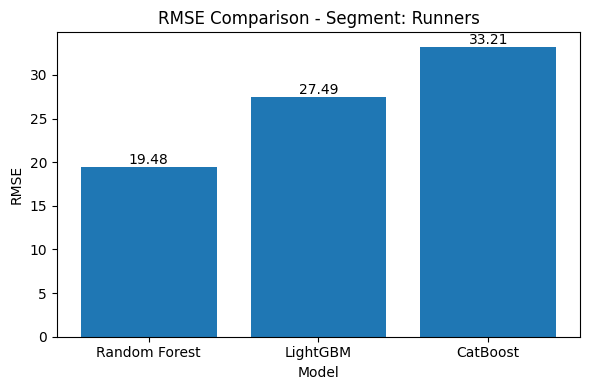

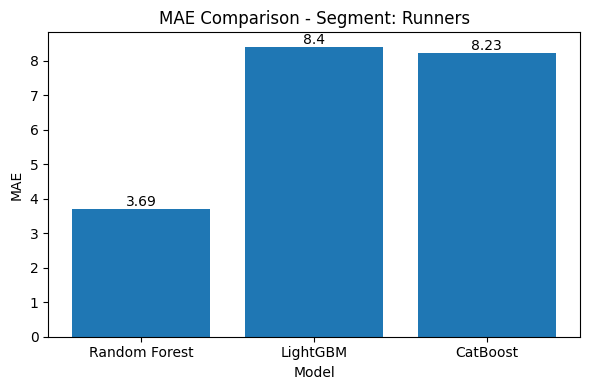

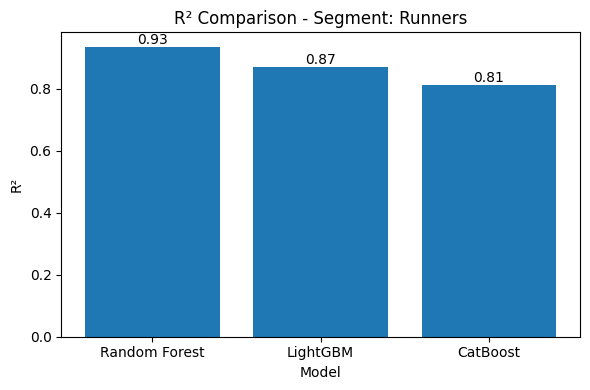

In [6]:
import matplotlib.pyplot as plt

# Stocker les scores
results = {
    'Model': [],
    'RMSE': [],
    'MAE': [],
    'R²': []
}

# Refaire la boucle pour stocker les valeurs
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results['Model'].append(name)
    results['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
    results['MAE'].append(mean_absolute_error(y_test, y_pred))
    results['R²'].append(r2_score(y_test, y_pred))

# Convertir en DataFrame pour tracé
results_df = pd.DataFrame(results)

# 📊 Affichage des graphes
metrics = ['RMSE', 'MAE', 'R²']
for metric in metrics:
    plt.figure(figsize=(6, 4))
    bars = plt.bar(results_df['Model'], results_df[metric])
    plt.title(f'{metric} Comparison - Segment: {segment}')
    plt.ylabel(metric)
    plt.xlabel('Model')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()


In [8]:
# ----------- Étape 1 : Calculer moyenne prix par année (2022-2024) -----------
price_by_year = subset[subset['Year'].isin([2022, 2023, 2024])]
price_avg = price_by_year.groupby(['Product_nettoyée', 'Year'])['UnitCostToEuro'].mean().unstack()
price_avg.columns = ['Prix_2022', 'Prix_2023', 'Prix_2024']
price_avg.reset_index(inplace=True)

# ❗️ Supprimer les produits sans aucune année disponible
price_avg = price_avg.dropna(how='all', subset=['Prix_2022', 'Prix_2023', 'Prix_2024'])

# ----------- Étape 2 : Moyenne de QTY et Month par produit pour les données 2025 -----------
qty_month_avg = subset.groupby('Product_nettoyée')[['QTY', 'Month']].mean().reset_index()
encoded = subset[['Product_nettoyée', 'ProductEncoded']].drop_duplicates()
products_2025 = pd.merge(price_avg[['Product_nettoyée']], encoded, on='Product_nettoyée', how='left')
products_2025 = pd.merge(products_2025, qty_month_avg, on='Product_nettoyée', how='left')
products_2025['Year'] = 2025

X_2025 = products_2025[['ProductEncoded', 'QTY', 'Year', 'Month']]

# ----------- Étape 3 : Réentraîner Random Forest sur tout l’historique -----------
X_train = subset[['ProductEncoded', 'QTY', 'Year', 'Month']]
y_train = subset['UnitCostToEuro']
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# ----------- Étape 4 : Prédiction -----------
products_2025['Prix_2025_Prediction'] = rf_model.predict(X_2025)

# ----------- Étape 5 : Fusion et export -----------
final_df = pd.merge(products_2025[['Product_nettoyée', 'Prix_2025_Prediction']], price_avg, on='Product_nettoyée', how='left')
final_df = final_df[['Product_nettoyée', 'Prix_2022', 'Prix_2023', 'Prix_2024', 'Prix_2025_Prediction']]

# Optionnel : Remplacer les NaN par vide ou 0 si tu veux un fichier propre
final_df.fillna("—", inplace=True)  # ou .fillna(0)

# Export
output_path = '/content/drive/MyDrive/Previsions_Runners_2025_FINALES.xlsx'
final_df.to_excel(output_path, index=False)
print(f"✅ Fichier final exporté ici : {output_path}")


✅ Fichier final exporté ici : /content/drive/MyDrive/Previsions_Runners_2025_FINALES.xlsx


<ipython-input-8-b1d12998ce64>:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '—' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  final_df.fillna("—", inplace=True)  # ou .fillna(0)
